In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [11]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [12]:
# Data loading and preprocessing
def load_data(batch_size=128):
    """
    Load and preprocess MNIST data.

    Parameters:
    batch_size (int): The number of samples per batch.

    Returns:
    tuple: DataLoaders for training, validation, and test sets.
    """
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])

    mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
    train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
    test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

    loader_kwargs = {'batch_size': batch_size, 'num_workers': 2, 'pin_memory': True, 'shuffle': True}
    train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
    validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
    test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

    return train_loader, validation_loader, test_loader

In [13]:
# Generic training function
def train(model, device, train_loader, optimizer):
    """
    Train the model for one epoch.

    Parameters:
    model (torch.nn.Module): The neural network model to train.
    device (torch.device): The device (CPU/GPU) to use for training.
    train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    optimizer (torch.optim.Optimizer): The optimizer used for training.

    Returns:
    float: The average training loss for the epoch.
    """
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    return train_loss

In [14]:
# Generic testing/validation function
def evaluate(model, device, loader, set_name='Test set'):
    """
    Evaluate the model on a dataset.

    Parameters:
    model (torch.nn.Module): The neural network model to evaluate.
    device (torch.device): The device (CPU/GPU) to use for evaluation.
    loader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate on.
    set_name (str): Name of the dataset (for logging purposes).

    Returns:
    tuple: Average loss and accuracy on the dataset.
    """
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    logging.info(f'{set_name}: Average loss: {loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({100. * accuracy:.2f}%)')
    return loss, accuracy

In [15]:
# Prediction function
def generate_predictions(model, device, loader):
    """
    Generate predictions for a dataset.

    Parameters:
    model (torch.nn.Module): The neural network model to use for predictions.
    device (torch.device): The device (CPU/GPU) to use for generating predictions.
    loader (torch.utils.data.DataLoader): DataLoader for the dataset.

    Returns:
    tuple: Arrays of predicted and true labels.
    """
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

In [16]:
# Confusion matrix plotting
def plot_confusion_matrix(preds, targets, title):
    """
    Plot a confusion matrix.

    Parameters:
    preds (np.array): Array of predicted labels.
    targets (np.array): Array of true labels.
    title (str): Title for the confusion matrix plot.
    """
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()

In [17]:
# Define models
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class Deep(nn.Module):
    def __init__(self):
        super(Deep, self).__init__()
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 64)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Perceptron - Test Accuracy: 98.15%


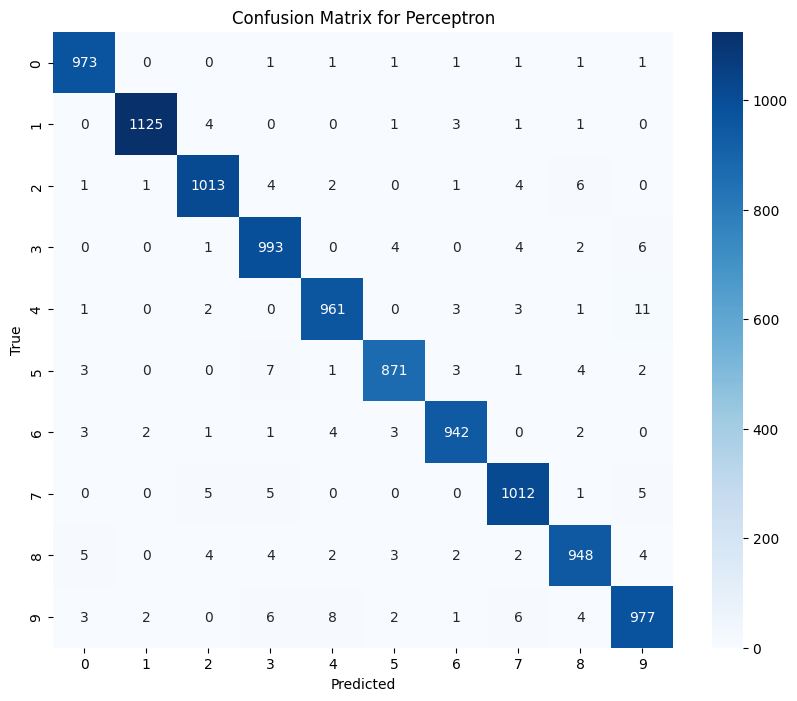

Deep Model - Test Accuracy: 95.76%


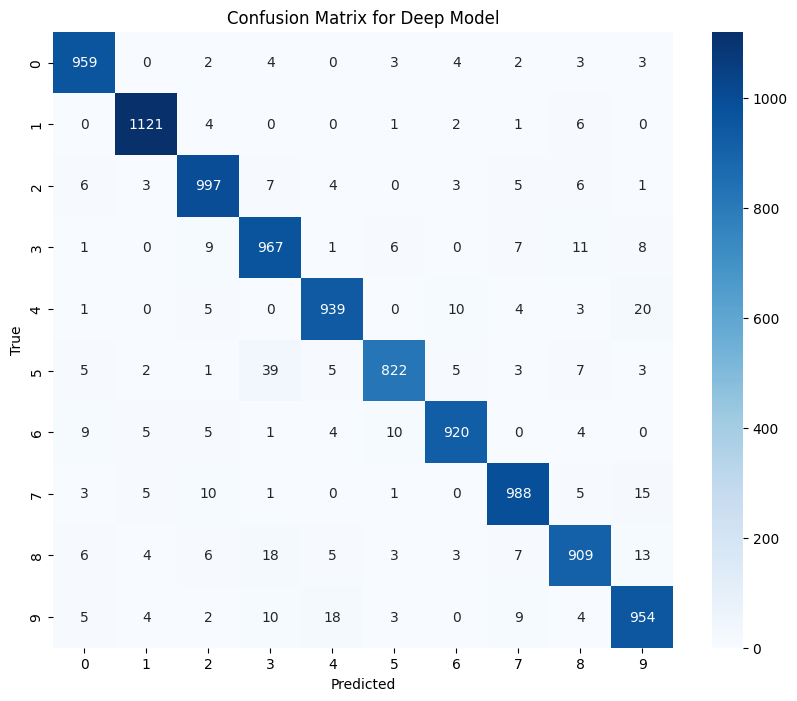

CNN - Test Accuracy: 96.59%


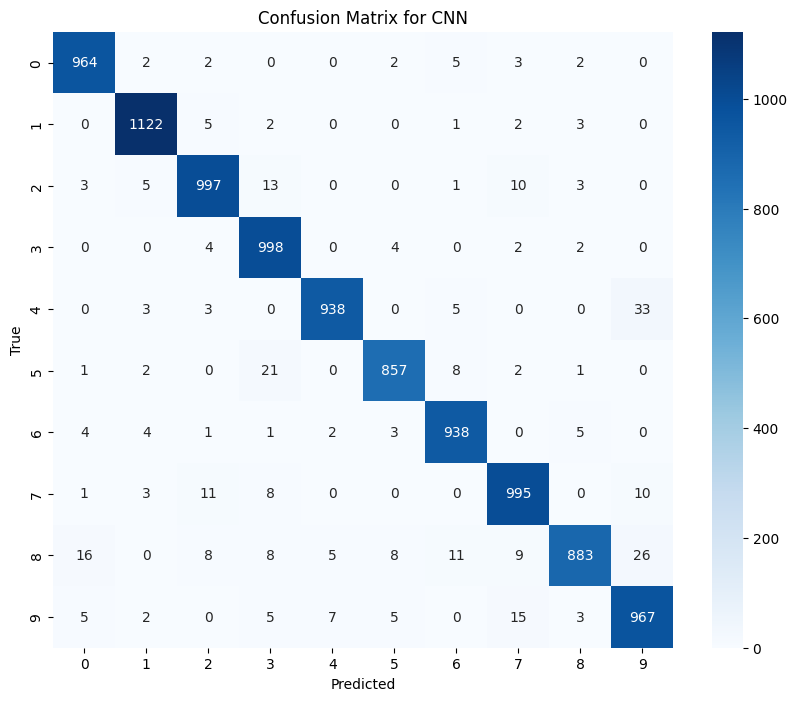

In [24]:
# Training and evaluation loop
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, validation_loader, test_loader = load_data()

    models = {
        "Perceptron": Perceptron(),
        "Deep Model": Deep(),
        "CNN": CNN()
    }

    for model_name, model in models.items():
        model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
        logging.info(f"Training {model_name}")

        for epoch_number in range(1, 51):
            train_loss = train(model, device, train_loader, optimizer)
            validation_loss, validation_accuracy = evaluate(model, device, validation_loader, 'Validation set')

        # Evaluate on the test set
        test_loss, test_accuracy = evaluate(model, device, test_loader, 'Test set')
        print(f'{model_name} - Test Accuracy: {test_accuracy * 100:.2f}%')

        # Generate predictions and plot confusion matrix
        preds, targets = generate_predictions(model, device, test_loader)
        plot_confusion_matrix(preds, targets, model_name)

run_experiment()